

# Project: Investigate Kaggle's European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling_matches">Data Wrangling: Matches</a></li>
<li><a href="#eda_matches">Exploratory Data Analysis: Matches</a></li>
<li><a href="#wrangling_players">Data Wrangling: Players</a></li>
<li><a href="#eda_players">Exploratory Data Analysis: Players</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='introduction'></a>
## Introduction

As a soccer fan and season pass holder for the Netherlands' best football club Ajax, it was not hard to choose between the datasets provided for this project. Picking the most interesting research questions, however, was much more difficult: with dozens of variables for matches, teams and individual players, there were literally hundreds of questions to answer. After much thought, I decided to extract two datasets from the SQLite database (the SQL statements that I used are described in the next cell):

* Matches (league name, date, home team, away team and the goals scored for the respective teams)
* Players (a combination of the tables 'player' and 'player_attributes')

For these datasets, I will try to answer the following research questions:
1. Is there an advantage for teams to playing in their own stadium (home advantage)?
2. How did the Dutch football club Ajax perform over the years, compared to its main competitors PSV and Feyenoord?
3. Are there more professional football players born in the first months of the year than in the last months of the year ([relative age effect](https://en.wikipedia.org/wiki/Relative_age_effect))?
4. Are there player characteristics that correspond to higher overall rating in the EA Sports FIFA video game? 

The European Soccer database was stored in a SQLite database. I used the software 'DB Browser for SQLite' and the following SQL statements to extract the datasets I needed:

__Matches__

```mysql
SELECT l.name AS league_name, m.season, m.date, t1.team_long_name as home_team, t2.team_long_name AS away_team, m.home_team_goal, m.away_team_goal
FROM Match m
JOIN League l
ON m.league_id = l.id
INNER JOIN Team as t1
ON m.home_team_api_id = t1.team_api_id
INNER JOIN Team as t2
ON m.away_team_api_id = t2.team_api_id;
```

__Players__
``` mysql
SELECT *
FROM Player_Attributes pa
JOIN Player p
ON p.player_api_id = pa.player_api_id;
```

In [1277]:
#Import statements for libraries needed for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import calendar
% matplotlib inline

In [1278]:
#Set display options in order the inspect the data in the extensive datasets properly
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

<a id='wrangling_matches'></a>
## Data Wrangling: Matches

In [1225]:
#Import dataset
matches = pd.read_csv('matches.csv')

### Notes on data cleaning and wrangling: Matches

* There were no duplicate rows in the Matches dataframe, so no action had to be taken. 
* In the 25979 rows in the dataframe, no null values were found. 
* The dates in column 'date' were strings when imported, I converted this column to datetime format
* To be able to make statements about the presumed advantage for teams playing in their home stadium, I created a new column for net score column.
* For the last research question about my favourite team Ajax, I created a filtered dataframe. I added a new column to this dataframe based on the net score in which the number of points for Ajax were calculated (in football, you will get 3 points for a win, 1 point for a draw and no points for a loss). I did the same for Ajax' competitors PSV and Feyenoord.

In [1226]:
#Find number of duplicate rows
sum(matches.duplicated())

0

In [1227]:
#Check if there are any null values in the dataframe
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 7 columns):
league_name       25979 non-null object
season            25979 non-null object
date              25979 non-null object
home_team         25979 non-null object
away_team         25979 non-null object
home_team_goal    25979 non-null int64
away_team_goal    25979 non-null int64
dtypes: int64(2), object(5)
memory usage: 1.4+ MB


In [1228]:
#Column 'date' is currently a string, convert to datetime format
matches['date'] = pd.to_datetime(matches['date'])

In [1229]:
#Create new column with day of week
matches['day_of_week'] = matches['date'].dt.weekday_name

In [1230]:
#Calculate the net score for each game. This new column will be used to determine if it is a home or away win (or draw)
net_score = matches['home_team_goal'] - matches['away_team_goal']
matches['net_score'] = net_score

In [1231]:
#Create separate dataframe with Ajax matches only and do the same for the main competitors PSV and Feyenoord
ajax = matches[(matches.home_team == 'Ajax') | (matches.away_team == 'Ajax')]
ajax = ajax.drop(columns=['league_name'])
psv = matches[(matches.home_team == 'PSV') | (matches.away_team == 'PSV')]
psv = psv.drop(columns=['league_name'])
feyenoord = matches[(matches.home_team == 'Feyenoord') | (matches.away_team == 'Feyenoord')]
feyenoord = feyenoord.drop(columns=['league_name'])

In [1232]:
#Write function to calculate the number of points for the team that is being investigated. In football, 3 points
#are awarded for a win, 1 point for a draw and 0 points for a loss. 
def points(row, team):
    if (row['net_score'] > 0) and (row['home_team'] == team):
        return 3
    elif (row['net_score'] < 0) and (row['away_team'] == team):
        return 3
    elif (row['net_score'] > 0) and (row['away_team'] == team):
        return 0
    elif (row['net_score'] < 0) and (row['home_team'] == team):
        return 0
    else:
        return 1

In [1280]:
#Create new column in the team dataframes that contains the number of points earned per match
ajax['points_ajax'] = ajax.apply(lambda row: points(row, 'Ajax'), axis=1)
psv['points_psv'] = psv.apply(lambda row: points(row, 'PSV'), axis=1)
feyenoord['points_feyenoord'] = feyenoord.apply(lambda row: points(row, 'Feyenoord'), axis=1)

In [1234]:
#Write function to calculate the number of goals for the team that is being investigated.
def goals(row, team):
    if row['home_team'] == team:
        return row['home_team_goal']
    else:
        return row['away_team_goal']

In [1235]:
#Create new column in the team dataframes that contains the number of goals scored per match
ajax['goals_ajax'] = ajax.apply(lambda row: goals(row, 'Ajax'), axis=1)
psv['goals_psv'] = psv.apply(lambda row: goals(row, 'PSV'), axis=1)
feyenoord['goals_feyenoord'] = feyenoord.apply(lambda row: goals(row, 'Feyenoord'), axis=1)

<a id='eda_matches'></a>
## Exploratory Data Analysis: Matches


### Research Question 1: Is there an advantage for teams to playing in their own stadium?

In [1236]:
#Explore contents of dataframe for reference
matches.head()

,league_name,season,date,home_team,away_team,home_team_goal,away_team_goal,day_of_week,net_score
0,Belgium Jupiler League,2008/2009,2008-08-17,KRC Genk,Beerschot AC,1,1,Sunday,0
1,Belgium Jupiler League,2008/2009,2008-08-16,SV Zulte-Waregem,Sporting Lokeren,0,0,Saturday,0
2,Belgium Jupiler League,2008/2009,2008-08-16,KSV Cercle Brugge,RSC Anderlecht,0,3,Saturday,-3
3,Belgium Jupiler League,2008/2009,2008-08-17,KAA Gent,RAEC Mons,5,0,Sunday,5
4,Belgium Jupiler League,2008/2009,2008-08-16,FCV Dender EH,Standard de Liège,1,3,Saturday,-2


In [1237]:
#Descriptive statistics for the matches dataset
matches.describe()

,home_team_goal,away_team_goal,net_score
count,25979.000000,25979.000000,25979.000000
mean,1.544594,1.160938,0.383656
std,1.297158,1.142110,1.782403
min,0.000000,0.000000,-9.000000
25%,1.000000,0.000000,-1.000000
50%,1.000000,1.000000,0.000000
75%,2.000000,2.000000,1.000000
max,10.000000,9.000000,10.000000


If a home advantage exists, one would expect the mean net score to be zero, which means that on average, the same number of goals are scored by the home team and the away team. The mean net score for this dataset, however, is 0.38. To see if this result is statistically significant, I ran a one sample t-test to compare the mean net score to the mean net score to be expected without home advantage (0).

The formula for the one sample t-test is:
  
$t = \frac{m-\mu}{s/\sqrt{n}}$

Using the mean and the standard deviation for net_score from the table above:

$t = \frac{0.383656-0}{1.782403/\sqrt{25979}} = 34.69$

Looking up this value in a ([T-Distribution table](http://www.statisticshowto.com/tables/t-distribution-table/)) learns that the p-value for this score is lower than the lowest p-value in the table. By conventional criteria, this difference in net score is considered to be statistically significant, so we can say that there is indeed an advantage for teams playing in their home stadium.

Although the phenomenon of home advantage is widely known in many sports, there is still much debate about the underlying reasons for it. Is it the cheering crowd, the familiarity of the stadium, the fact that players do not have to travel and sleep in their own bed, or even the [referee](https://www.researchgate.net/publication/259824788_Home_advantage_and_referee_bias_in_European_football) who may be biased?

[One researcher](http://onlinelibrary.wiley.com/doi/10.1111/ecin.12465/full) even suggested that the home advantage for teams in the German Bundesliga dissapears when a match is played in the middle of the week. Indeed, the average net score is lower when playing matches on Tuesday, Wednesday or Thursday but the home advantage does not dissapear completely, at least not for matches for the German Bundesliga period 2008-2016.

In [1281]:
matches[(matches.league_name == 'Germany 1. Bundesliga') & ((matches.day_of_week == 'Tuesday') | (matches.day_of_week == 'Wednesday') | (matches.day_of_week == 'Thursday'))].mean()

home_team_goal    1.617391
away_team_goal    1.382609
net_score         0.234783
dtype: float64

The extent to which the home advantage occurs varies between the leagues in the dataset. It would be plausible to expect that the home advantage is greater when the distances between home and away clubs are long. However, looking at the chart below, this seems not the case. Although the lowest mean net score is seen in the relative small country of Switzerland (which would fit the hypothesis), the highest mean net score is measured in Belgium, the smallest country in the dataset. 

Text(0.5,1,'Mean net score per league')

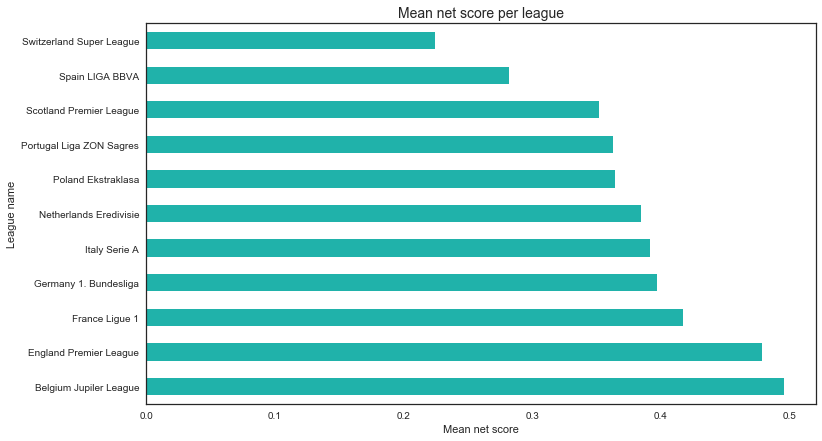

In [1285]:
#Create bar chart for the net score per league
mean_net_score = matches.pivot_table(index='league_name', values='net_score', aggfunc=np.mean)
ax = mean_net_score.sort_values(by='net_score', ascending=False).plot.barh(x=mean_net_score.index, y='net_score', figsize=(12, 7), legend=False, color='lightseagreen')
ax.set_xlabel("Mean net score")
ax.set_ylabel("League name")
ax.grid(False)
plt.title('Mean net score per league', fontsize=14)

### Research Question 2: How did the Dutch football club Ajax perform over the years, compared to its main competitors PSV and Feyenoord?

In the Netherlands, the highest football league Eredivisie is historically dominated by three clubs: Ajax from Amsterdam, PSV from Eindhoven and Feyenoord from Rotterdam. How did Ajax perform in terms of the number of points earned per season and the number of goals scored compared to its competitors?

In [1286]:
#Create a combined dataframe of pivot tables, in order to compare the number of points earned per season
points_a = ajax.pivot_table(index='season', values=['points_ajax'],aggfunc=np.sum) 
points_p = psv.pivot_table(index='season', values=['points_psv'],aggfunc=np.sum)
points_f = feyenoord.pivot_table(index='season', values=['points_feyenoord'],aggfunc=np.sum) 
dfs = [points_a, points_p, points_f]
combined_points = pd.concat(dfs, axis=1)

,points_ajax
season,
2008/2009,68
2009/2010,85
2010/2011,73
2011/2012,76
2012/2013,76
2013/2014,71
2014/2015,71
2015/2016,82


Text(0.5,1,'Big Three: Points per season')

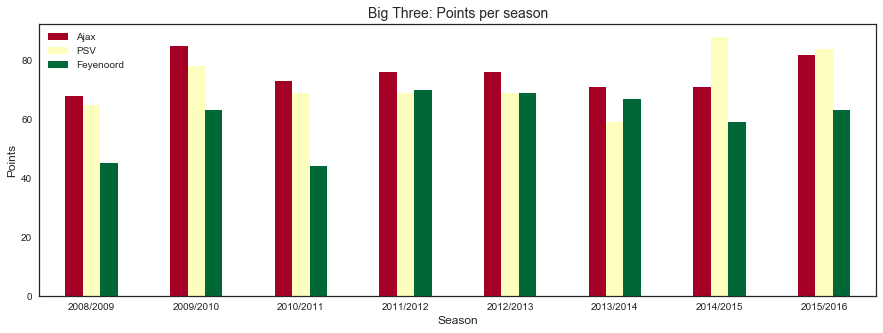

In [1241]:
#Create grouped bar chart for the total number of points per season, per team
labels = ['Ajax', 'PSV', 'Feyenoord']
ax = combined_points.plot(kind='bar',figsize=(15,5), rot=0, colormap='RdYlGn')
ax.legend(labels)
ax.grid(False)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Points', fontsize=12)
plt.title('Big Three: Points per season', fontsize=14)

Over the the seasons between 2008 and 2016, Ajax was the overall winner with regard of the number of points earned, with PSV as runner up. However, in the first two seasons in the dataset there was a for the Dutch Eredivisie very special situation to have a champion that was not from the Big Three (see table below). The champion with the most points was PSV in season 2014/2015 (88 points), whereas Ajax only got 71 points and still won the league in 2013/2014. For Feyenoord, 2018-2016 were not the best years, with an all-time low in season 2010/2011 when the club ended up 10th place in the final rankings with only 44 points.


| Season | Champion |
|------|------|
| 2008/2009 | AZ |
| 2009/2010 | FC Twente|
| 2010/2011 | Ajax |
| 2011/2012 | Ajax |
| 2012/2013 | Ajax |
| 2013/2014 | Ajax |
| 2014/2015 | PSV |
| 2015/2016 | PSV|

In [1242]:
#Create a combined dataframe of pivot tables, in order to compare the number of goals scored per season
goals_a = ajax.pivot_table(index='season', values=['goals_ajax'],aggfunc=np.sum) 
goals_p = psv.pivot_table(index='season', values=['goals_psv'],aggfunc=np.sum)
goals_f = feyenoord.pivot_table(index='season', values=['goals_feyenoord'],aggfunc=np.sum) 
dfs_g = [goals_a, goals_p, goals_f]
combined_goals = pd.concat(dfs_g, axis=1)

Text(0.5,1,'Big Three: Goals per season')

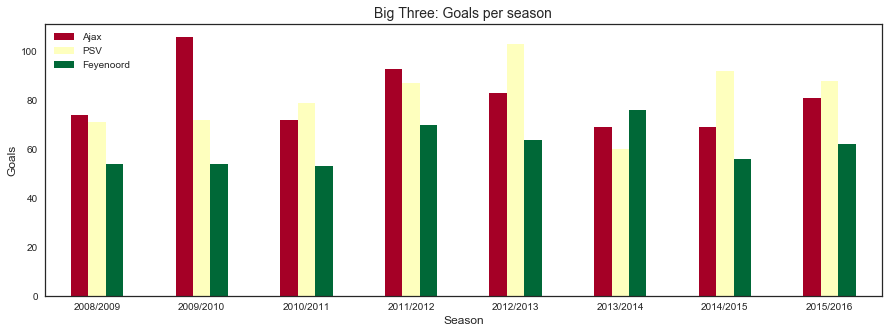

In [1243]:
#Create grouped bar chart for the total number of goals per season, per team
ax = combined_goals.plot(kind='bar',figsize=(15,5), rot=0, colormap='RdYlGn')
ax.legend(labels, loc='upper left')
ax.grid(False)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Goals', fontsize=12)
plt.title('Big Three: Goals per season', fontsize=14)

The chart shows that the club that scores the most goals is not the champion by definition. For three out of four seasons (2010/2011 to 2013/2014) in which Ajax became champion, another team (PSV twice, Feyenoord once) scored more goals. As a result, in the period covered by this dataset, Ajax is the club that became champion with the fewest goals (69, in season 2013/2014). True to their famous offensive playing style, Ajax is also responsible for the most goals in one season in this dataset: 106 goals in season 2009/2010 (the season in which the title was grabbed by AZ Alkmaar). 

<a id='wrangling_players'></a>
## Data Wrangling: Players

In [1287]:
#load player data
players = pd.read_csv('player_names_attributes.csv', index_col='id')

### Notes on data cleaning and wrangling: Players

* There was one duplicate row in the players dataframe, I decided to drop that one row.  
* In the players dataset that originally contained more than 183.000 rows, there were 3230 rows that contained null values. Because I wanted to make statements about larger groups of players (as opposed to making sure that every individual player is present in the dataset) I decided to drop all rows with null values. 
* As weight is measured in kilograms in the Netherlands, I converted the column "weight" to kilograms instead of lbs.
* I added a column 'BMI' (Body Mass Index) to have a little more information about the ratio between weight and height.
* To be able to compare the ages of players, I first converted every row in the column 'birthday' to a datetime object and created a new column "age" from that. I borrowed the code for calculating the age at time of measurement [here](https://stackoverflow.com/questions/34279378/python-pandas-apply-function-with-two-arguments-to-columns) and [here](https://stackoverflow.com/questions/765797/python-timedelta-in-years).

In [1245]:
#To make the dataframe a bit more manageable, columns that will not be used are dropped
players = players.drop(columns=['player_fifa_api_id', 'player_api_id', 'id.1', 'player_api_id.1', 'player_fifa_api_id.1'])

In [1246]:
#Count number of duplicate rows and drop duplicates
sum(players.duplicated())
players.drop_duplicates(inplace=True)

In [1247]:
#Check if there are any null values in the dataframe
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183977 entries, 1 to 183978
Data columns (total 43 columns):
date                   183977 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
acceleration           183142 non-null float64
sprint_speed           183142 non-null float64
agility                181265 non-null float64


In [1248]:
#Find number of rows with missing values per column
players.isnull().sum()
#Drop rows with missing values
players.dropna(axis=0, how='any', inplace=True)
#Running players.info() again learns that every column now has the same number (180354) of non-null values.

In [1249]:
#Create new column 'weight_kg' that contains the player's weight in kilograms
weight_kg = players['weight'] * 0.45359237
players['weight_kg'] = weight_kg

In [1250]:
#Calculate BMI with the following formula: weight in kilograms/height in meters squared
bmi = players['weight_kg']/(players['height']/100)**2
players['bmi'] = bmi

In [1251]:
#Function to calculate the age of the player on the rating date
players['birthday'] = pd.to_datetime(players['birthday'])
players['date'] = pd.to_datetime(players['date'])

def num_years(start, end):
    num_years = int((end - start).days / 365.25)
    return num_years
    
players['age'] = players.apply(lambda x: num_years(x['birthday'], x['date']), axis=1)

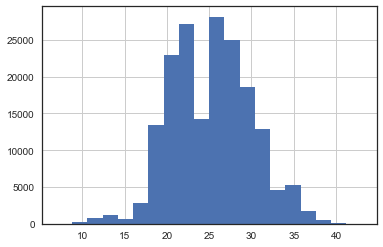

In [1252]:
players['age'].hist(bins=20)

When checking the distribution for the newly created column 'age', apparently there are players younger than 15 or even 10 years at the time of ranking. As this is not possible for professional football players, I ran a query on the players younger than 15 (see cell below). It seems that there is a problem with one of the ranking dates (February 22, 2007). Therefore, when I want to investigate age later in this report, I will leave out the measurements of February 2007. I do not prefer to drop those rows because there are no problems with the rest of the data. 

In [1253]:
players.query('age < 15')

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2007-02-22,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye,1992-02-29,182.88,187,84.821773,25.361499,14
146,2007-02-22,60.0,77.0,right,medium,high,47.0,31.0,46.0,63.0,33.0,53.0,55.0,39.0,63.0,62.0,72.0,67.0,60.0,60.0,80.0,52.0,71.0,68.0,59.0,37.0,74.0,54.0,50.0,58.0,41.0,51.0,56.0,56.0,7.0,12.0,13.0,13.0,14.0,Aaron Kuhl,1996-01-30,172.72,146,66.224486,22.198996,11
179,2007-02-22,48.0,57.0,right,medium,medium,12.0,15.0,16.0,23.0,14.0,15.0,14.0,18.0,18.0,22.0,15.0,26.0,31.0,45.0,24.0,26.0,38.0,18.0,44.0,12.0,21.0,19.0,14.0,15.0,41.0,15.0,15.0,12.0,53.0,41.0,39.0,51.0,53.0,Aaron Lennox,1993-02-19,190.50,181,82.100219,22.623217,14
317,2007-02-22,55.0,63.0,left,medium,medium,54.0,51.0,42.0,60.0,41.0,52.0,44.0,42.0,51.0,51.0,65.0,66.0,62.0,52.0,60.0,53.0,52.0,56.0,40.0,51.0,48.0,29.0,51.0,54.0,54.0,42.0,46.0,44.0,10.0,12.0,7.0,13.0,8.0,Aaron Splaine,1996-10-13,172.72,163,73.935556,24.783811,10
459,2007-02-22,63.0,72.0,left,medium,medium,42.0,52.0,39.0,64.0,40.0,72.0,67.0,45.0,56.0,67.0,75.0,78.0,82.0,62.0,72.0,48.0,65.0,62.0,53.0,52.0,40.0,23.0,46.0,64.0,46.0,32.0,33.0,40.0,8.0,13.0,8.0,15.0,8.0,Abdelmalek El Hasnaoui,1994-02-09,180.34,159,72.121187,22.175771,13
500,2007-02-22,62.0,70.0,left,medium,medium,41.0,29.0,60.0,58.0,36.0,46.0,40.0,31.0,43.0,49.0,59.0,64.0,46.0,50.0,64.0,41.0,73.0,68.0,55.0,23.0,58.0,61.0,29.0,32.0,40.0,64.0,70.0,67.0,11.0,6.0,6.0,6.0,7.0,Abdou Diallo,1996-05-04,182.88,159,72.121187,21.564055,10
532,2007-02-22,63.0,66.0,right,medium,medium,34.0,29.0,55.0,56.0,31.0,35.0,26.0,29.0,32.0,51.0,59.0,71.0,47.0,55.0,25.0,40.0,65.0,52.0,95.0,26.0,48.0,58.0,27.0,30.0,46.0,62.0,68.0,63.0,8.0,10.0,12.0,11.0,14.0,Abdoul Ba,1994-02-08,200.66,212,96.161582,23.882511,13
714,2007-02-22,57.0,75.0,right,medium,medium,23.0,23.0,23.0,39.0,36.0,23.0,14.0,9.0,47.0,28.0,42.0,32.0,57.0,70.0,58.0,45.0,66.0,46.0,55.0,23.0,23.0,30.0,18.0,33.0,22.0,23.0,23.0,20.0,58.0,59.0,47.0,39.0,74.0,Abdoulaye Diallo,1992-03-30,187.96,174,78.925072,22.340049,14
732,2007-02-22,55.0,72.0,right,medium,medium,47.0,32.0,53.0,59.0,23.0,51.0,28.0,30.0,52.0,56.0,63.0,57.0,68.0,52.0,62.0,51.0,71.0,54.0,58.0,28.0,62.0,58.0,35.0,47.0,44.0,43.0,61.0,57.0,14.0,11.0,11.0,14.0,13.0,Abdoulaye Doucoure,1993-01-01,182.88,165,74.842741,22.377793,14


In [1254]:
#Create new column with birth month (research question 3)
players['birth_month'] = players['birthday'].dt.month

In [1255]:
#Create dataframe with unique players to count every birthday just once
unique_players = players.drop_duplicates(['player_name'])
unique_players['birth_month'] = unique_players['birth_month'].apply(lambda x: calendar.month_abbr[x])

/Users/marielle/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


<a id='eda_players'></a>
## Exploratory Data Analysis: Players


### Research Question 3:  Are there more professional football players born in the first months of the year than in the last months of the year? 

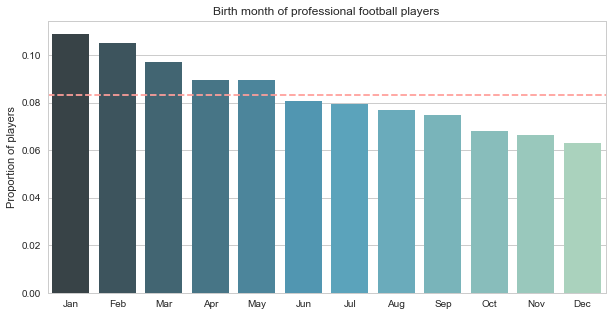

In [1256]:
#Create barplot with the proportion of players born in a specific month
counts = unique_players['birth_month'].value_counts(normalize=True)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep","Oct", "Nov", "Dec"]
mean = 1/12

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=months, y=counts, palette='GnBu_d')
plt.ylabel("Proportion of players")
plt.title('Birth month of professional football players')
plt.axhline(mean, color='r', linestyle='--', label='mean')


On Wikipedia, the relative age effect is defined as follows:

> The term relative age effect (RAE) is used to describe a bias, evident in the upper echelons of youth sport and academia, where participation is higher amongst those born early in the relevant selection period (and correspondingly lower amongst those born late in the selection period) than would be expected from the normalised distribution of live births. 

In Europe, the selection year for football starts at January 1st. Therefore, if a relative age effect is present, an overrepresentation of birth months in the first quarter of the year is expected. Looking at the table above, this trend is indeed visible. Unfortunately, at this point during my study, I cannot determine whether this difference is significant or if this observed distribution is due to chance. Nevertheless, as many researchers have demonstrated the existence of the relative age effect both in sports and education, the trend in the chart above does seem to indicate that an age effect exists for the professional football players in the dataset. 


### Research Question 4: Are there player characteristics that correspond to higher overall rating in the EA Sports FIFA video game?

In [1257]:
players.describe()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,height,weight,weight_kg,bmi,age,birth_month
count,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.00000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000
mean,68.635317,73.479457,55.142071,49.962136,57.263476,62.486726,49.488927,59.265755,53.001408,49.392783,57.084578,63.453846,67.709405,68.101628,65.995082,66.148297,65.190082,61.866474,66.977333,67.053401,67.432477,53.387560,60.946217,51.897374,55.730730,57.868176,54.933448,46.757433,50.354065,48.029342,14.696685,15.947786,20.526304,16.015043,16.32531,181.877895,168.774593,76.554868,23.117492,25.161993,5.961204
std,7.027950,6.581963,17.247231,19.041760,16.478716,14.172493,18.252319,17.741351,18.245476,17.820262,14.412035,15.187692,13.011580,12.585984,12.963670,9.145011,13.076192,16.129537,11.017828,13.200669,12.085131,18.370204,16.101618,19.483338,18.458218,15.152408,15.556645,21.226730,21.496289,21.592830,16.841454,15.841297,21.143898,16.070772,17.18545,6.398588,15.098388,6.848513,1.337586,4.719768,3.434750
min,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,2.000000,1.000000,3.000000,5.000000,10.000000,12.000000,11.000000,17.000000,12.000000,2.000000,14.000000,10.000000,10.000000,1.000000,6.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,157.480000,117.000000,53.070307,17.868393,7.000000,1.000000
25%,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,52.000000,41.000000,36.000000,49.000000,59.000000,61.000000,62.000000,58.000000,61.000000,58.000000,54.000000,60.000000,61.000000,60.000000,41.000000,51.000000,34.000000,45.000000,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.00000,177.800000,159.000000,72.121187,22.175771,22.000000,3.000000
50%,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,64.000000,56.000000,50.000000,59.000000,67.000000,69.000000,69.000000,68.000000,67.000000,67.000000,66.000000,68.000000,69.000000,69.000000,58.000000,64.000000,56.000000,60.000000,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.00000,182.880000,168.000000,76.203518,23.100858,25.000000,6.000000
75%,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,72.000000,67.000000,63.000000,67.000000,73.000000,77.000000,77.000000,75.000000,72.000000,74.000000,73.000000,74.000000,76.000000,76.000000,67.000000,73.000000,68.000000,69.000000,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.00000,185.420000,179.000000,81.193034,23.988885,28.000000,9.000000
max,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,97.000000,94.000000,97.000000,97.000000,97.000000,97.000000,97.000000,96.000000,96.000000,96.000000,97.000000,96.000000,96.000000,96.000000,96.000000,97.000000,96.000000,95.000000,97.000000,96.000000,94.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.00000,208.280000,243.000000,110.222946,30.865728,43.000000,12.000000


In general, you can quickly see that there is a lot of variation in the mean and standard deviation across the various FIFA attributes. But the dry numbers become much more interesting (at least to me) when you realize that behind every extreme value, there are names of real players. For example, the world of difference between the top player with overall ranking of 94 (FC Barcelona's Lionel Messi) and the one with the lowest ranking (the Italian player Francesco Della Rocco who, fortunately for him, was very young when his first ranking was set and later reached an overall rating of 68 (__[source](https://sofifa.com/player/178043)__). The best header (the rather unknown Nicola Zigic), the most agile player (again, Lionel Messi amongst others), the most aggressive player (not surprisingly: Gennaro Gattuso, amongst others) and the one who scores penalties best (Rickie Lambert)... it is tempting to connect all attributes to names. 

There is also a lot of variation in age, weight and height. For age, there is probably an error in the data because the minimum age is 7 in the dataset. I will deal with this problem before making statements about age.

To conclude, the tallest player in the set is Kristof van Hout, a Belgian goalkeeper who measures 2.08 meters and is also the heaviest player. The smallest player is Juan Quero, a Spanish midfielder, who is -with his 53 kilograms- also the lightest player in the set. 

In [1258]:
#Find names for extreme values from the descriptive statistics table
players.query('overall_rating == 94')
players.query('overall_rating == 33')
players.query('heading_accuracy == 98')
players.query('aggression == 97')
players.query('penalties == 96')
players.query('age == 43')
players.query('height >= 208')
players.query('height <= 158')
players.query('weight_kg >= 110')
players.query('weight_kg < 53.1')

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
90617,2012-02-22,64.0,65.0,right,medium,low,56.0,51.0,45.0,53.0,53.0,71.0,64.0,59.0,49.0,64.0,92.0,90.0,92.0,70.0,95.0,58.0,70.0,62.0,27.0,52.0,37.0,23.0,63.0,52.0,65.0,27.0,13.0,21.0,6.0,15.0,8.0,11.0,5.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,27,10
90618,2011-08-30,63.0,64.0,right,high,medium,56.0,51.0,45.0,53.0,53.0,63.0,64.0,59.0,49.0,64.0,89.0,86.0,87.0,70.0,95.0,58.0,69.0,62.0,27.0,52.0,37.0,23.0,63.0,52.0,65.0,27.0,13.0,21.0,6.0,15.0,8.0,11.0,5.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,26,10
90619,2011-02-22,66.0,76.0,right,high,medium,57.0,56.0,46.0,54.0,54.0,65.0,65.0,60.0,50.0,66.0,87.0,85.0,84.0,69.0,60.0,63.0,62.0,65.0,38.0,53.0,38.0,24.0,64.0,53.0,66.0,28.0,14.0,22.0,6.0,15.0,8.0,11.0,5.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,26,10
90620,2010-08-30,66.0,76.0,right,high,medium,57.0,56.0,46.0,54.0,54.0,65.0,65.0,60.0,50.0,66.0,87.0,85.0,84.0,69.0,60.0,63.0,62.0,65.0,38.0,53.0,38.0,24.0,64.0,53.0,66.0,28.0,14.0,22.0,6.0,15.0,8.0,11.0,5.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,25,10
90621,2010-02-22,70.0,76.0,right,high,medium,62.0,61.0,46.0,59.0,54.0,71.0,65.0,60.0,57.0,70.0,87.0,86.0,84.0,69.0,60.0,69.0,62.0,68.0,28.0,62.0,38.0,56.0,54.0,53.0,61.0,28.0,23.0,22.0,6.0,23.0,57.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,25,10
90622,2009-08-30,71.0,76.0,right,high,medium,66.0,61.0,46.0,59.0,54.0,71.0,65.0,60.0,57.0,70.0,87.0,86.0,84.0,69.0,60.0,69.0,62.0,68.0,28.0,62.0,38.0,56.0,54.0,53.0,61.0,28.0,23.0,22.0,6.0,23.0,57.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,24,10
90623,2009-02-22,71.0,77.0,left,high,medium,76.0,71.0,47.0,70.0,54.0,78.0,65.0,61.0,68.0,73.0,87.0,84.0,84.0,70.0,60.0,70.0,62.0,69.0,30.0,63.0,50.0,57.0,55.0,53.0,62.0,29.0,23.0,22.0,6.0,23.0,68.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,24,10
90624,2008-08-30,71.0,73.0,left,high,medium,76.0,77.0,57.0,74.0,54.0,78.0,65.0,61.0,72.0,73.0,77.0,74.0,84.0,70.0,60.0,70.0,62.0,69.0,60.0,63.0,50.0,57.0,55.0,53.0,62.0,49.0,40.0,22.0,6.0,23.0,72.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,23,10
90625,2007-08-30,63.0,67.0,left,high,medium,54.0,68.0,57.0,63.0,54.0,60.0,65.0,50.0,60.0,67.0,60.0,72.0,84.0,70.0,60.0,50.0,62.0,68.0,60.0,51.0,50.0,57.0,55.0,53.0,62.0,49.0,40.0,22.0,6.0,23.0,60.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,22,10


Correlation between overall rating and potential, reactions and dribbling respectively:
0.7654346716757737
0.771856096662733
0.3541906009384681


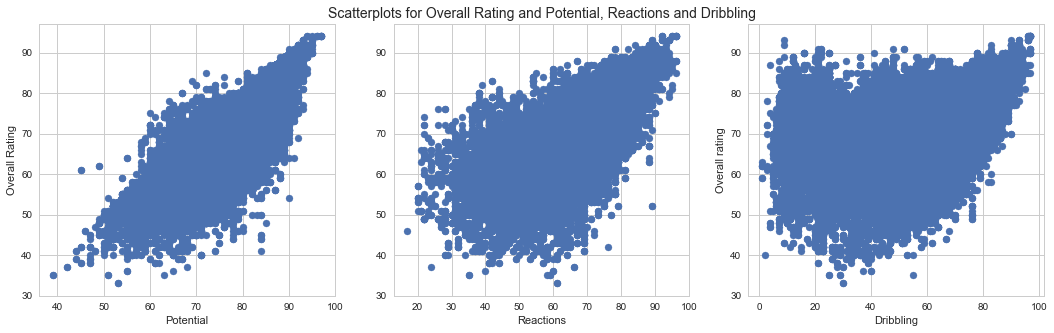

In [1259]:
#Create scatterplot for overall rating and some FIFA variables: potential, reactions and dribbling
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,1)
ax1.scatter(players['potential'], players['overall_rating'])
plt.xlabel('Potential')
plt.ylabel('Overall Rating')
ax2 = fig.add_subplot(1,3,2)
ax2.scatter(players['reactions'], players['overall_rating'])
plt.xlabel('Reactions')
plt.title('Scatterplots for Overall Rating and Potential, Reactions and Dribbling', fontsize=14)
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(players['dribbling'], players['overall_rating'])
plt.xlabel('Dribbling')
plt.ylabel('Overall rating')

#Calculate Pearson correlation coefficient for overall rating and potential/reactions/dribbling
print('Correlation between overall rating and potential, reactions and dribbling respectively:')
print(players['potential'].corr(players['overall_rating']))
print(players['reactions'].corr(players['overall_rating']))
print(players['dribbling'].corr(players['overall_rating']))

To determine which player characteristics correspond to a higher overall FIFA rating, I first created scatterplots for every FIFA attribute and see if they are positively correlated (ie higher ratings on a specific attribute tend to go together with high overall ratings). To improve readability of this report, there are just three scatterplots in the cell above (the same code was used for every scatterplot).

Although I expected a strong correlation between the overall rating and at least some of the more general player characteristics like strength or stamina, this is not always the case. In fact, only potential (which makes sense for high rated players) and reactions did show a very strong positive relationship with overall rating. 

*Overview of Pearson correlation coefficient between overall rating and:*
* potential: 0.77
* crossing: 0.36
* finishing: 0.33
* heading accuracy: 0.31
* short_passing: 0.46
* volleys: 0.36
* dribbling: 0.35
* curve: 0.36
* free_kick_accuracy: 0.35
* long_passing: 0.44
* ball_control: 0.44
* acceleration: 0.26
* sprint_speed: 0.25
* agility: 0.24
* reactions: 0.77
* balance: 0.16
* shot_power: 0.43
* jumping: 0.26
* stamina: 0.33
* strength: 0.32
* long_shots: 0.39
* aggression: 0.32
* interceptions: 0.25
* positioning: 0.37
* vision: 0.43
* penalties: 0.39
* marking: 0.13
* standing_tackle: 0.13
* sliding_tackle: 0.13

I added these results to a dictionary and used this dictionary to create a bar chart.

[Text(0,0,'potential'),
 Text(0,0,'reactions'),
 Text(0,0,'short passing'),
 Text(0,0,'long passing'),
 Text(0,0,'ball control'),
 Text(0,0,'shot power'),
 Text(0,0,'vision'),
 Text(0,0,'long shots'),
 Text(0,0,'penalties'),
 Text(0,0,'positioning'),
 Text(0,0,'volleys'),
 Text(0,0,'crossing'),
 Text(0,0,'curve'),
 Text(0,0,'dribbling'),
 Text(0,0,'free kick accuracy'),
 Text(0,0,'finishing'),
 Text(0,0,'stamina'),
 Text(0,0,'strength'),
 Text(0,0,'aggression'),
 Text(0,0,'heading accuracy'),
 Text(0,0,'jumping'),
 Text(0,0,'acceleration'),
 Text(0,0,'sprint speed'),
 Text(0,0,'interceptions'),
 Text(0,0,'agility'),
 Text(0,0,'balance'),
 Text(0,0,'marking'),
 Text(0,0,'standing tackle'),
 Text(0,0,'sliding tackle')]

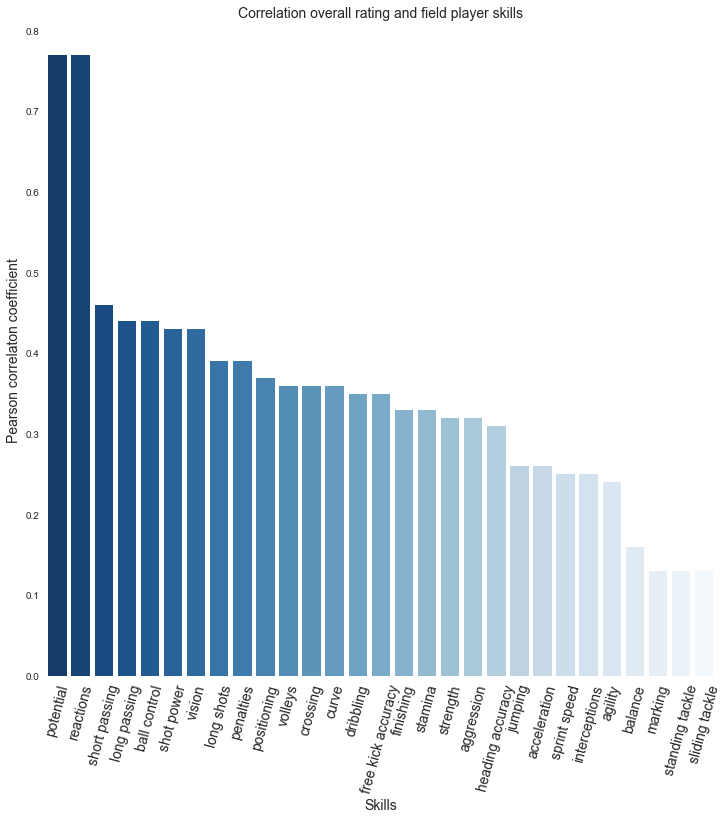

In [1288]:
#Create bar chart for skills that show the highest correlation with overall rating
skills = ['potential', 'reactions', 'short passing', 'long passing', 'ball control', 'shot power', 'vision', 
          'long shots', 'penalties', 'positioning', 'volleys', 'crossing', 'curve', 'dribbling', 'free kick accuracy', 
          'finishing', 'stamina', 'strength', 'aggression', 'heading accuracy', 'jumping', 'acceleration', 
          'sprint speed', 'interceptions', 'agility', 'balance', 'marking', 'standing tackle', 'sliding tackle']
r =  [0.77, 0.77, 0.46, 0.44, 0.44, 0.43, 0.43, 0.39, 0.39, 0.37, 0.36, 0.36, 0.36, 0.35, 0.35, 0.33, 0.33, 0.32, 0.32, 
      0.31, 0.26, 0.26, 0.25, 0.25, 0.24, 0.16, 0.13, 0.13, 0.13]

fig, ax = plt.subplots(figsize=(12,12))
sns.set_style("dark")
sns.barplot(x=skills, y=r, palette='Blues_r')
sns.despine(left=True, bottom=True)
plt.xlabel('Skills', fontsize=14)
plt.ylabel('Pearson correlaton coefficient', fontsize=14)
plt.title('Correlation overall rating and field player skills', fontsize=14)
ax.set_xticklabels(skills, rotation=75, fontsize=14)

The remaining characteristics are all specific for goalkeepers so I would like to correlate these characteristics only to the goalkeepers in the dataset. Unfortunately, there is no single identifier to separate the goalies from the field players. I would have expected the columns with the goalkeeper characteristics to be empty for the field players but unfortunately that is not the case. At sofifa.com, the site that contains all the player ratings for EA Sports game FIFA 18, it appears that field players do not have a rating higher than 40 for the GK reflexes attitude, which means that if we filter the player data on gk_reflexes we should only have goalkeepers. To be on the safe side, I chose 50 as a threshold for goalkeeping reflexes.

Looking at the list of unique names in the goalkeepers dataset (see cell below), there are a lot of familiar (goalkeeper) names. Googling some random unknown names learns that can safely assume this indeed is a list of goalkeepers only.

In [1261]:
gk = players[players['gk_reflexes'] >= 50]
gk['player_name'].unique()

array(['Aaron Lennox', 'Abdoulaye Diallo', 'Achille Coser', 'Adam Bogdan',
       'Adam Collin', 'Adam Federici', 'Adrian', 'Adriano Facchini',
       'Alan Combe', 'Alan Mannus', 'Alan Martin', 'Alban Lafont',
       'Albano Benjamin Bizzarri', 'Alberto Brignoli',
       'Alberto Cifuentes', 'Alberto Frison,18', 'Alberto Garcia',
       'Alberto Maria Fontana', 'Alberto Pelagotti', 'Alberto Pomini',
       'Alessandro Damen', 'Alessandro Iacobucci', 'Alessio Cragno',
       'Alessio Scarpi', 'Alex Calderoni', 'Alex Manninger',
       'Alex McCarthy', 'Alex Valentini', 'Alexander Schwolow',
       'Alexander Stephan', 'Alexandre Letellier', 'Alexandros Tzorvas',
       'Alexis Thebaux', 'Alfonso De Lucia', 'Ali Ahamada',
       'Ali Al-Habsi', 'Alireza Haghighi', 'Allan McGregor',
       'Alphonse Areola', 'Anders Lindegaard', 'Andre Lenz',
       'Andre Moreira', 'Andrea Campagnolo', 'Andrea Consigli',
       'Andrea Guatelli', 'Andrea Seculin', 'Andreas Hirzel',
       'Andreas Isaks

Next, we can see which goalkeeper characteristics correlate most strongly with the overall rating of the goalkeeper in the same way as the field players earlier. 

*Overview of Pearson correlation coefficient between overall rating and:*
* Diving: 0.91
* Handling: 0.89
* Kicking: 0.70
* Positioning: 0.90
* Reflexes: 0.91

As expected, all attributes that are specific to goalkeepers are strongly correlated with the overall rating of the goalkeeper. Only kicking skills seem to go together with high overall ratings a little less often, but there is still a strong positive relation with the overall rating. Because there were only a few characteristics that contributed to a higher overall rating for the field players, I decided not to analyze them all for the goalkeepers as well but try a different angle first.

Next to looking into the attributes that go together with a higher overall rating, you can also create two groups: one with a high overall rating (top 25%) and one with a low rating (bottom 25%), and see if there are any differences between the two groups. I created an additional filter to leave out the goalkeepers, as the skill scores for goalkeepers and field players are too different. 

In [1262]:
#Create two subgroups from the players dataframe, based on the first and third quartile values for overall rating
#Exclude goalkeepers
top_players = players[(players['overall_rating'] > 73) & (players['gk_reflexes'] <= 40)]
bottom_players = players[(players['overall_rating'] < 64) & (players['gk_reflexes'] <= 40)]

In [1263]:
#Descriptive statistics for the top players 
top_players.describe()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,height,weight,weight_kg,bmi,age,birth_month
count,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000
mean,77.390846,80.425412,66.402173,61.393238,67.137264,74.169681,61.825729,71.221360,65.118296,60.622678,67.495276,75.682241,73.612279,73.961919,71.479556,75.446894,69.658709,73.461247,70.352228,74.323642,71.675381,65.969242,69.052069,60.516490,68.000146,69.236983,65.550983,52.705358,57.791285,54.560845,9.938801,11.494886,18.409472,11.481411,11.473624,181.175258,168.323252,76.350143,23.234713,26.691542,5.917930
std,3.203293,4.067879,13.468866,17.333100,12.577857,7.583528,16.170790,12.859475,15.304138,16.086753,11.065133,7.983775,11.253138,10.401303,11.971172,5.569219,12.362079,10.147063,10.961097,9.751874,11.569328,14.842395,13.832182,20.453973,15.242947,11.808822,12.962678,23.371014,22.635362,23.311201,3.413556,5.051522,20.581070,5.149520,5.162128,6.428243,14.970649,6.790572,1.322210,3.827990,3.402011
min,74.000000,60.000000,11.000000,10.000000,18.000000,32.000000,11.000000,16.000000,11.000000,10.000000,14.000000,15.000000,22.000000,24.000000,19.000000,39.000000,22.000000,7.000000,25.000000,26.000000,25.000000,10.000000,8.000000,11.000000,16.000000,16.000000,10.000000,7.000000,9.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,160.020000,123.000000,55.791862,18.359925,12.000000,1.000000
25%,75.000000,77.000000,60.000000,50.000000,59.000000,70.000000,53.000000,66.000000,57.000000,50.000000,61.000000,73.000000,68.000000,68.000000,65.000000,72.000000,62.000000,69.000000,64.000000,69.000000,65.000000,60.000000,61.000000,41.000000,63.000000,63.000000,58.000000,28.000000,35.000000,31.000000,7.000000,8.000000,8.000000,8.000000,8.000000,175.260000,159.000000,72.121187,22.377793,24.000000,3.000000
50%,77.000000,80.000000,70.000000,65.000000,69.000000,75.000000,66.000000,74.000000,68.000000,64.000000,69.000000,77.000000,75.000000,75.000000,73.000000,75.000000,72.000000,75.000000,71.000000,75.000000,74.000000,70.000000,72.000000,69.000000,73.000000,72.000000,68.000000,59.000000,67.000000,63.000000,10.000000,11.000000,11.000000,11.000000,11.000000,180.340000,168.000000,76.203518,23.220163,27.000000,6.000000
75%,79.000000,83.000000,76.000000,75.000000,77.000000,79.000000,74.000000,80.000000,76.000000,73.000000,75.000000,81.000000,81.000000,81.000000,79.000000,79.000000,78.000000,80.000000,78.000000,81.000000,79.000000,76.000000,79.000000,77.000000,78.000000,77.000000,75.000000,75.000000,78.000000,76.000000,13.000000,14.000000,14.000000,14.000000,14.000000,185.420000,179.000000,81.193034,24.101069,29.000000,9.000000
max,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,97.000000,94.000000,97.000000,97.000000,97.000000,97.000000,96.000000,96.000000,96.000000,96.000000,97.000000,96.000000,96.000000,96.000000,96.000000,97.000000,96.000000,95.000000,97.000000,96.000000,94.000000,95.000000,95.000000,32.000000,33.000000,97.000000,33.000000,37.000000,203.200000,220.000000,99.790321,30.865728,41.000000,12.000000


In [1264]:
#Descriptive statistics for the bottom players
bottom_players.describe()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,height,weight,weight_kg,bmi,age,birth_month
count,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.00000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000
mean,59.090573,67.358317,49.080382,43.855755,52.791024,56.197497,43.171291,53.822437,46.522328,42.920710,50.104936,57.138897,65.595683,65.924294,63.321332,56.806367,64.270207,54.114483,63.160260,62.608394,61.727693,45.42540,54.870034,46.994316,49.051040,51.144721,48.960859,44.660554,47.709158,46.571493,9.520900,12.079542,17.448554,12.115043,11.988269,181.202193,165.694711,75.157857,22.872128,21.899768,5.868326
std,3.978516,5.650055,11.711083,14.824853,10.454492,9.190476,13.228894,11.852856,12.384599,12.273502,10.793875,8.466406,9.722151,9.475019,10.766753,7.344736,11.241960,12.344400,10.573578,10.180917,12.335999,13.49019,13.247807,14.696548,12.765259,11.449543,11.338902,16.336672,16.809249,17.124938,3.518672,5.291114,15.986205,5.259921,5.283761,6.007415,14.160355,6.423029,1.359690,4.683221,3.456308
min,33.000000,39.000000,8.000000,7.000000,2.000000,15.000000,5.000000,1.000000,11.000000,6.000000,11.000000,15.000000,22.000000,23.000000,22.000000,17.000000,21.000000,10.000000,21.000000,20.000000,13.000000,8.00000,10.000000,10.000000,8.000000,10.000000,8.000000,5.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,157.480000,117.000000,53.070307,17.868393,8.000000,1.000000
25%,57.000000,63.000000,41.000000,31.000000,46.000000,51.000000,33.000000,48.000000,37.000000,33.000000,43.000000,53.000000,60.000000,61.000000,57.000000,52.000000,58.000000,47.000000,57.000000,56.000000,55.000000,35.00000,46.000000,36.000000,42.000000,44.000000,42.000000,28.000000,31.000000,31.000000,7.000000,8.000000,8.000000,8.000000,8.000000,177.800000,154.000000,69.853225,22.083267,19.000000,3.000000
50%,60.000000,67.000000,51.000000,45.000000,54.000000,58.000000,44.000000,57.000000,47.000000,42.000000,52.000000,59.000000,66.000000,67.000000,64.000000,57.000000,65.000000,56.000000,63.000000,63.000000,62.000000,48.00000,57.000000,51.000000,52.000000,52.000000,50.000000,49.000000,54.000000,53.000000,9.000000,11.000000,11.000000,11.000000,11.000000,180.340000,165.000000,74.842741,22.813890,21.000000,6.000000
75%,62.000000,71.000000,58.000000,57.000000,61.000000,63.000000,53.000000,62.000000,56.000000,52.000000,58.000000,63.000000,72.000000,72.000000,71.000000,62.000000,72.000000,63.000000,71.000000,70.000000,71.000000,56.00000,64.000000,59.000000,58.000000,59.000000,57.000000,59.000000,62.000000,61.000000,12.000000,14.000000,15.000000,14.000000,14.000000,185.420000,174.000000,78.925072,23.709944,25.000000,9.000000
max,63.000000,90.000000,78.000000,79.000000,90.000000,90.000000,87.000000,83.000000,89.000000,91.000000,80.000000,84.000000,97.000000,97.000000,94.000000,89.000000,96.000000,87.000000,94.000000,94.000000,95.000000,83.00000,92.000000,89.000000,91.000000,91.000000,90.000000,78.000000,80.000000,83.000000,63.000000,63.000000,80.000000,63.000000,40.000000,208.280000,243.000000,110.222946,30.865728,39.000000,12.000000


Comparing the means of the numerical variables gives a good understanding of the skills you obviously need as a top player: the largest differences (>19 points in mean rating between top and bottom players) can be seen on the attributes long shots and shot power, followed by (>18 points difference in mean rating) ball control, reactions, positioning, vision, volleys and curve. 

To see the shape of the distributions, I created two visuals below: one for an attribute that is typical for top players (finishing) and one for which the mean rating for top players is almost the same as for bottom players (sliding tackle). 

The distribution for finishing is as I expected (bottom players to the left with lower rating, top players on the right), but the distribution of the sliding tackles appears to be bimodal for the top players. It is a good example of a situation where just comparing the mean can be deceptive because when looking at the median for both groups, the top players once again come out as winners when it comes to their sliding tackle skills. It is also interesting to realize that apparently, there are two pretty distinct groups: one group of top players who have poor sliding tackle skills (a plausible hypothesis would be that this group mainly consists of attackers) and one group of top players that have good sliding tackle skills. 

Text(0.5,1,'Distribution of rating for players on attribute "Finishing"')

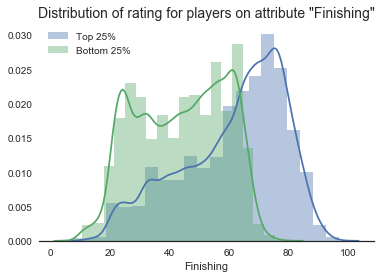

In [1265]:
#Create histogram for attribute "finishing" with kernel density estimation (KDE)
labels = ['Top 25%', 'Bottom 25%']
sns.set_style("white")
sns.distplot(top_players['finishing'], bins=20)
sns.distplot(bottom_players['finishing'], bins=20)
sns.despine(left=True)
plt.legend(labels, loc = 'upper left')
plt.xlabel('Finishing')
plt.title('Distribution of rating for players on attribute "Finishing"', fontsize=14)

Text(0.5,1,'Distribution of rating for players on attribute "Sliding Tackle"')

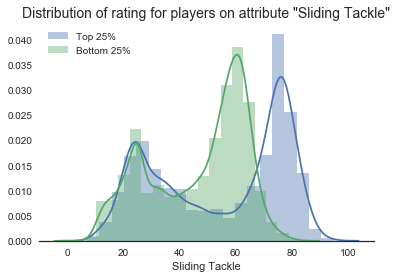

In [1266]:
#Create histogram for attribute "sliding tackle" with kernel density estimation (KDE)
sns.set_style("white")
sns.distplot(top_players['sliding_tackle'], bins=20)
sns.distplot(bottom_players['sliding_tackle'], bins=20)
sns.despine(left=True)
plt.legend(labels, loc = 'upper left')
plt.xlabel('Sliding Tackle')
plt.title('Distribution of rating for players on attribute "Sliding Tackle"', fontsize=14)

In [1267]:
#Print median for attribute "sliding tackle" in two groups
print(top_players['sliding_tackle'].median())
print(bottom_players['sliding_tackle'].median())

63.0
53.0


Plotting the distribution of age of the top players and the bottom player (to be precise: the distribution of age at each moment a player is rated as top 25% or bottom 25%, which means that the same player can appear in this distribution more than once) learns that top players are -on average- older than the bottom players. This can be explained by the fact that it will take some years before you reach your top ranking, while the younger bottom players still have room to grow (even with the filter on low potential). 

Text(0.5,1,'Distribution of rating for players on age')

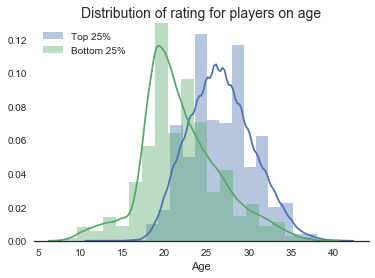

In [1268]:
#Create histogram for age with kernel density estimation (KDE)
sns.set_style("white")
sns.distplot(top_players['age'], bins=20)
sns.distplot(bottom_players['age'], bins=20)
sns.despine(left=True)
plt.legend(labels, loc = 'upper left')
plt.xlabel('Age')
plt.title('Distribution of rating for players on age', fontsize=14)

As said before, the same player can appear in the dataset multiple times. For the FIFA scores and age, this is not a problem, because they correspond to a certain moment in time (no player will be constant throughout his career). For height and weight, however, the data can be skewed if these constant values are included multiple times. Therefore I will filter the data for unique player names.

In [1269]:
#Filter data on unique field players, leave ranking date February 2007 (see earlier comment)
filtered_all = players[(players['date'].dt.year > 2007)]
unique_all = filtered_all.drop_duplicates(['player_name'])

#Descriptive statistics for weight and height for field players
unique_all[['height', 'weight_kg', 'bmi']].describe()

,height,weight_kg,bmi
count,10226.000000,10226.000000,10226.000000
mean,181.888193,76.385337,23.063426
std,6.379521,6.817598,1.325602
min,157.480000,53.070307,17.868393
25%,177.800000,72.121187,22.164701
50%,182.880000,76.203518,23.055908
75%,185.420000,81.193034,23.871523
max,208.280000,110.222946,30.865728


In [1270]:
#Filter data on unique goalkeepers, leave ranking date February 2007 (see earlier comment)
filtered_g = gk[(gk['date'].dt.year > 2007)]
unique_gk = filtered_g.drop_duplicates(['player_name'])

#Descriptive statistics for weight and height for goalkeepers
unique_gk[['height', 'weight_kg', 'bmi']].describe()

,height,weight_kg,bmi
count,886.000000,886.000000,886.000000
mean,188.745508,83.664242,23.480090
std,4.697721,5.853611,1.331518
min,172.720000,63.956524,18.745276
25%,185.420000,79.832257,22.623217
50%,187.960000,83.007404,23.479133
75%,193.040000,87.089735,24.365990
max,208.280000,110.222946,29.578585


It is clear to see that goalkeepers are taller and heavier than field players, on average. This comes as no suprise: at least in the Netherlands, talent scouts look for tall goalkeepers. My favourite football club Ajax even does a hand measurement for young goalkeepers to predict if they will reach a minimum height set by the club. 

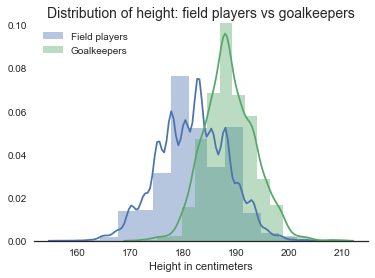

In [1271]:
#Create histogram for height with kernel density estimation (KDE), compare field players to goal keepers
sns.set_style("white")
sns.distplot(unique_all['height'], bins=15, label='Field players')
sns.distplot(unique_gk['height'], bins=15, label='Goalkeepers')
plt.legend(loc='upper left')
plt.xlabel('Height in centimeters')
plt.title('Distribution of height: field players vs goalkeepers', fontsize=14)
sns.despine(left=True)

Let's see if there is also a difference in weight and height between top and bottom players. The tables below indeed show a small difference in weight and height for top players compared to bottom players: the top players are a little lighter and smaller than the bottom players, on average. Although I do not have the means at this point to see if this difference is significant, I suspect that (also taking the BMI into account) that there is no significant difference in weight and height for the top 25% players compared to the bottom 25% players. 

In [1272]:
#Decriptive statistics for unique players in the top 25% player group
filtered = top_players[(top_players['date'].dt.year > 2007)]
unique_top = top_players.drop_duplicates(['player_name'])

unique_top[['height', 'weight_kg', 'bmi']].describe()

,height,weight_kg,bmi
count,3342.000000,3342.000000,3342.000000
mean,181.240628,76.289975,23.201741
std,6.290970,6.655869,1.315294
min,160.020000,55.791862,18.359925
25%,177.800000,72.121187,22.377793
50%,180.340000,76.203518,23.184609
75%,185.420000,81.193034,24.070645
max,203.200000,99.790321,30.865728


In [1273]:
#Decriptive statistics for unique players in the bottom 25% player group
filtered_b = bottom_players[(bottom_players['date'].dt.year > 2007)]
unique_bottom = filtered_b.drop_duplicates(['player_name'])

unique_bottom[['height', 'weight_kg', 'bmi']].describe()

,height,weight_kg,bmi
count,5647.000000,5647.000000,5647.000000
mean,181.224300,75.255368,22.893921
std,6.048255,6.444633,1.322134
min,157.480000,53.070307,17.868393
25%,177.800000,71.214002,22.096473
50%,180.340000,74.842741,22.813890
75%,185.420000,79.832257,23.752351
max,208.280000,110.222946,30.865728


There is one interesting (categorical) variable left to which the two player groups can be compared: preferred foot. Is there a difference in footedness between top and bottom players? This is a pretty difficult question to answer because to start with, there are no conclusive statistics on the percentage of footedness for all people but as a reference, I used the 19% leftfootedness found on [Wikipedia](https://en.wikipedia.org/wiki/Laterality). Comparing this statistic to the statistics below, leftfootedness does seem to be more common among football players compared to the general population. Leftfootedness is seen a little more often among bottom players in this dataset.  

At this moment in the course, I am not entirely sure which statistical method I can use to check if this difference is significant or not but I suspect it is a Chi square test. If I run a Chi square test online, I do find a significant difference in footedness between the whole population and both top and bottom players. This could be an indication that professional football players are more often leftfooted than people who do not play football (or, at least not on a professional level).

In [1274]:
print(unique_top['preferred_foot'].value_counts(normalize=True))
print(unique_bottom['preferred_foot'].value_counts(normalize=True))

right    0.754339
left     0.245661
Name: preferred_foot, dtype: float64
right    0.743758
left     0.256242
Name: preferred_foot, dtype: float64


<a id='conclusions'></a>
## Conclusions

After trying many roads and angles within this extensive dataset, I singled out four research questions. Not every research question were answered to my full satisfaction. For example: I hoped to create a sharper image of the characteristics of top football players than I eventually found in the data. On the other hand, it was nice to see some research questions answered and visualized like I suspected beforehand, for example with the question about the relative birth effect. 

**A summary of my findings:**

*Matches*
* The much debated home advantage where football teams benefit from playing in their own stadium does seem to exist. There are differences between the various leagues, though. The cause of these differences is not clear. The hypothesis that the home advantage is larger in larger countries (with longer travel distances between clubs) is not backed up by the data. 
* Matching with my own observations between 2008 and 2016 ;-), the data did indeed show that Ajax was successful in terms of points earned and goals scored, compared to eternal rivals PSV and Feyenoord. However, Ajax did not entirely live up to its reputation of having an offensive playing style because the team did not score the most goals in the majority of the seasons in the dataset. 

*Players*
* Looking at the months in which the professional football players in this dataset are born, it does seem that the relative age effect is present, because an overrepresentation of players born in the first months of the year can be observed. However, at this moment in time I do not have the tools to test if this overrepresentation is statistically significant or not.
* There is a strong correlation between the overall FIFA rating of the player and his reactions, which means that high overall ratings often go together with good reactions. Furthermore, the top 25% players have a larger mean rating on long shots and shot power, followed by ball control, reactions, positioning, vision, volleys and curve (as compared to the bottom 25% players). An important thing to keep in mind though is that these characteristics are no hard numbers but subjective ratings created for a video game. An interesting article on how the ratings are calculated can be found [here](https://www.vg247.com/2016/09/27/how-ea-calculates-fifa-17-player-ratings/).
* Goalkeepers are -on average- taller than field players. When comparing top to bottom players, there is also a small difference in weight and height: the top players are -on average- a little lighter and smaller than the bottom players. Although I do not have the means at this point to see if this difference is significant, I suspect that (also taking the BMI into account) that there is no significant difference in weight and height for the top 25% players compared to the bottom 25% players. 
